In [85]:
from __future__ import division

import argparse, time, logging, random, math, os, sys

import numpy as np
import mxnet as mx
import gluoncv as gcv
from skimage import util as sk_util
import cv2

from datetime import datetime
from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory, LRSequential, LRScheduler
from gluoncv.data import transforms as gcv_transforms
print("Imports successful")

Imports successful


In [86]:
per_device_batch_size = 256 # Batch Size for Each GPU
num_workers = 2             # Number of data loader workers
dtype = 'float32'           # Default training data type if float32
num_gpus = 1                # number of GPUs to use
batch_size = per_device_batch_size * num_gpus # Calculate effective total batch size

# For CIFAR100 Dataset:
num_classes = 100
num_images_per_class = 500
num_training_samples = num_classes * num_images_per_class
num_batches = num_training_samples // batch_size

## Smoothing

In [87]:
label_smoothing = True
def smooth(label, num_classes, eta=0.1):
    if isinstance(label, nd.NDArray):
        label = [label]
    smoothed = []
    for l in label:
        res = l.one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                     off_value = eta/num_classes)
        smoothed.append(res)
    return smoothed
print("\nUsing label smoothing: {}".format(label_smoothing))


Using label smoothing: True


## Mixup

In [88]:
mixup = False
def mixup_transform(label, num_classes, lam=1, eta=0.0):
    if isinstance(label, nd.NDArray):
        print("Label changed to list")
        label = [label]
    res = []
    for l in label:
        y1 = l.one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                    off_value = eta/num_classes)
        y2 = l[::-1].one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                          off_value = eta/num_classes)
        res.append(lam*y1 + (1-lam)*y2)
    return res
print("Using mixup: {}".format(mixup))

Using mixup: False


In [90]:
stitch_mixup = True
stitch_type = 'vertical'
def stitch_mixup_transform(X, lam, stitch_type='horizontal'):
    h1 = 32
    w1 = 32
    if lam < 1:
        Y = nd.zeros_like(X)
        if stitch_type == 'horizontal':
            Y[:,:,0:int(h1*lam),:] = X[:,:,0:int(h1*lam),:]
            Y[:,:,int(h1*lam):h1,:] = X[::-1,:,int(h1*lam):h1,:]
        elif stitch_type == 'vertical':
            Y[:,:,:,0:int(h1*lam)] = X[:,:,:,0:int(h1*lam)]
            Y[:,:,:,int(h1*lam):h1] = X[::-1,:,:,int(h1*lam):h1]
        else:
            raise("Invalid stitch type passed in!")
            return
        return Y
    else:
        return X
    
def stitch_mixup_label_transform(label, num_classes, lam=1, eta=0.0, stitch_type='horizontal'):
    if isinstance(label, nd.NDArray):
        print("Label changed to list")
        label = [label]
    res = []
    for l in label:
        y1 = l.one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                    off_value = eta/num_classes)
        y2 = l[::-1].one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                          off_value = eta/num_classes)
        res.append(lam*y1 + (1-lam)*y2)
    return res
print("Using spatial mixup: {}".format(stitch_mixup))
if stitch_mixup:
    print("Using {} spatial mixup.".format(stitch_type))

Using spatial mixup: True
Using vertical spatial mixup.


In [91]:
def add_img_noise(img_tensor, noise_type='gaussian'):
    """
    """
    reshaped_img = nd.reshape(img_tensor, (32, 32, 3))
    noise_img_numpy = sk_util.random_noise(reshaped_img.asnumpy(), 
                                           mode=noise_type, 
                                           seed=None, 
                                           clip=True)
    noise_img = nd.reshape(nd.array(noise_img_numpy), (3, 32, 32))
    return noise_img

# Model Init

In [92]:
ctx = [mx.gpu(i) for i in range(num_gpus)]

# last_gamma = False
# print("Using last gamma: {}".format(last_gamma))
# kwargs = {'ctx':ctx, 'classes':num_classes, 'last_gamma':last_gamma}

kwargs = {'ctx':ctx, 'classes':num_classes}

use_group_norm = False
if use_group_norm:
    kwargs['norm_layer'] = gcv.nn.GroupNorm
    print("Using Group Normalization: {}".format(use_group_norm))

default_init = True
net = get_model('cifar_resnet56_v1', **kwargs)

if default_init:
    net.initialize(mx.init.Xavier(), ctx = ctx)
else:
    net.initialize(mx.init.MSRAPrelu(), ctx=ctx)
    print("Using MSRA Prelu Init.")

    net.cast(dtype)
print("\nModel Init Done.")


Model Init Done.


# Distillation
Note that the reference paper uses a teacher model that was trained using cosine learning rate decay and label smoothing. 

Therefore I have created a separate notebook that trains the ResNext29_16x64d model using cosine learning rate decay and label smoothing on the CIFAR100 dataset. Training this ResNext29 architecture took nearly 10 hours...

What is left to do is now just to load the model architecture again, and load the parameters from the saved file.

### The old approach, when not using my own trained model is:
Load the pre-trained CIFAR10 models and replace the final output layer with 100 classes instead of 10. This is demonstrated at this website: https://mxnet.apache.org/versions/1.7.0/api/python/docs/tutorials/packages/gluon/image/pretrained_models.html

Need to investigate WideResNet issue of having Top1-Val Accuracies becoming 0.00000 at the very beginning of training. 

Additionally, need to understand the two ResNeXt architectures to understand why training time is much longer...:/

In [93]:
distillation = False

if distillation:
    curr_dir = os.getcwd()
    param_file = os.path.join(curr_dir, "resnext29_teacher.params") 
    T = 20
    hard_weight = 0.5
    # Teacher model for distillation training
    # teacher_name = 'cifar_resnet110_v2'
    # teacher_name = 'cifar_resnet56_v2'
    # teacher_name = 'cifar_wideresnet28_10' # Top1-Val is 0...
    # teacher_name = 'cifar_wideresnet40_8'  # Might cause the same problem
    # teacher_name = 'cifar_resnext29_32x4d' # This is apparently not available...?
    
    teacher_name = 'cifar_resnext29_16x64d'
#     teacher = get_model(teacher_name, pretrained=True, ctx=ctx)
#     #teacher.collect_params().initialize(ctx=ctx, force_reinit=True) # Don't do this.
#     teacher.cast(dtype)
#     with teacher.name_scope():
#         teacher.output = gluon.nn.Dense(num_classes)
#         teacher.output.initialize(mx.init.Xavier(), ctx=ctx)
    
    teacher = get_model(teacher_name, classes=num_classes, ctx=ctx)
    teacher.load_parameters(param_file)
    teacher.cast(dtype)
        
    print(teacher.output)
    print("\nTeacher Model Init Done!")
else:
    print("\nNot using distillation")


Not using distillation


In [94]:
resize = 32
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
max_aspect_ratio = 4.0 / 3.0
min_aspect_ratio = 3.0 / 4.0
max_random_area = 1
min_random_area = 0.08
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([    
#     transforms.RandomResizedCrop(resize,
#                                  scale=(min_random_area, max_random_area), 
#                                  ratio=(min_aspect_ratio, max_aspect_ratio)),
    
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    
    transforms.RandomBrightness(brightness=jitter_param),
    transforms.RandomSaturation(saturation=jitter_param),
    transforms.RandomHue(hue=jitter_param),
    
    transforms.RandomLighting(lighting_param),
    
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
        
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize(mean_rgb, std_rgb),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb),
])
print("Preprocessing Step Successful.")

Preprocessing Step Successful.


# Compose Image Transforms

In [95]:
# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=True).transform_first(transform_train),
    batch_size=batch_size, 
    shuffle=True, 
    last_batch='discard', 
    num_workers=num_workers)

# Set train=False for validation data
# Set shuffle=False to shuffle the testing data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=False).transform_first(transform_test),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers)
print("Initialization of train_data and val_data successful.")
print("Per Device Batch Size: {}".format(per_device_batch_size))

Initialization of train_data and val_data successful.
Per Device Batch Size: 256


# Training Settings

In [96]:
if mixup or stitch_mixup:
    epochs = 200 # Mixup asks for longer training to converge better
else:
    epochs = 120
    
warmup_epochs = 5
mixup_off_epochs = 0

alpha = 0.2 # For Beta distribution sampling

lr_decay_epochs = [30, 60, 90, np.inf] # Epochs where learning rate decays
# lr_decay_epochs = [40, 80]

warmup_lr_mode = 'linear'
lr_mode = 'cosine'
lr_decay = 0.1 # Learning rate decay factor
target_lr = 0

# Sets up a linear warmup scheduler, followed by a cosine rate decay.
# Consult the paper for the proper parameters (base_lr, target_lr, warmup_epochs, etc.)
lr_scheduler = LRSequential([
    LRScheduler(warmup_lr_mode,
                base_lr = 0,
                target_lr = 0.1,
                nepochs = warmup_epochs,
                iters_per_epoch = num_batches),
    
    LRScheduler(lr_mode,
                base_lr = 0.1,
                target_lr = target_lr,
                nepochs = epochs - warmup_epochs,
                iters_per_epoch = num_batches,
                step_epoch = lr_decay_epochs,
                step_factor = lr_decay,
                power = 2)
])

# Nesterov accelerated gradient descent and set parameters (based of off 
# reference papers and default values):
optimizer = 'nag'
optimizer_params = {'lr_scheduler': lr_scheduler, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

if label_smoothing or mixup:
    sparse_label_loss = False
else:
    sparse_label_loss = True

print("sparse label loss: {}".format(sparse_label_loss))

if distillation:
    loss_fn = gcv.loss.DistillationSoftmaxCrossEntropyLoss(temperature=T,
                                                           hard_weight=hard_weight,
                                                           sparse_label=sparse_label_loss)
else:
    loss_fn = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=sparse_label_loss)

train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])
train_history2 = TrainingHistory(['training-acc', 'val-acc-top1', 'val-acc-top5'])

print("\nUsing label smoothing: {}".format(label_smoothing))
print("\nUsing mixup: {}".format(mixup))
print("Number of no-mixup epochs:{}".format(mixup_off_epochs))

print("\nUsing {} Optimizer".format(optimizer))
print(optimizer_params)
print("\nNumber of warmup epochs: {}".format(warmup_epochs))
print("Warmup Learning Rate Mode: {}".format(warmup_lr_mode))
print("Learing Rate Mode: {}".format(lr_mode))
print("Learing Rate Decay: {}".format(lr_decay))
print("Learning Rate Decay Epochs: {}".format(lr_decay_epochs))
print("\nTraining Settings Set Successfully.")

sparse label loss: False

Using label smoothing: True

Using mixup: False
Number of no-mixup epochs:0

Using nag Optimizer
{'lr_scheduler': <gluoncv.utils.lr_scheduler.LRSequential object at 0x7f20fc273110>, 'wd': 0.0001, 'momentum': 0.9}

Number of warmup epochs: 5
Warmup Learning Rate Mode: linear
Learing Rate Mode: cosine
Learing Rate Decay: 0.1
Learning Rate Decay Epochs: [30, 60, 90, inf]

Training Settings Set Successfully.


# Test Function

In [97]:
acc_top1 = mx.metric.Accuracy()
acc_top5 = mx.metric.TopKAccuracy(5)

def test(ctx, val_data):
    acc_top1.reset()
    acc_top5.reset()
    
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X.astype(dtype, copy=False)) for X in data]
        acc_top1.update(label, outputs)
        acc_top5.update(label, outputs)
    
    _, top1 = acc_top1.get()
    _, top5 = acc_top5.get()
    
    return (top1, top5)

# Training Loop

Training loop started for 200 epochs:
[Epoch 0] train=1.000000 val_top1=0.152100 val_top5=0.475000 loss=179960.969727 time: 32.293359
[Epoch 1] train=1.000000 val_top1=0.213900 val_top5=0.598400 loss=157662.215210 time: 32.012706
[Epoch 2] train=1.000000 val_top1=0.268000 val_top5=0.649000 loss=149371.923096 time: 31.900178
[Epoch 3] train=1.000000 val_top1=0.353700 val_top5=0.746700 loss=139892.794312 time: 31.688125
[Epoch 4] train=1.000000 val_top1=0.335300 val_top5=0.727900 loss=133986.734314 time: 31.794324
[Epoch 5] train=1.000000 val_top1=0.405000 val_top5=0.788700 loss=125524.783936 time: 31.731749
[Epoch 6] train=1.000000 val_top1=0.507300 val_top5=0.864700 loss=121413.661926 time: 31.817410
[Epoch 7] train=1.000000 val_top1=0.523500 val_top5=0.866700 loss=118927.159576 time: 31.927963
[Epoch 8] train=1.000000 val_top1=0.547900 val_top5=0.882300 loss=116309.581055 time: 31.802178
[Epoch 9] train=1.000000 val_top1=0.545300 val_top5=0.875200 loss=112836.269562 time: 31.880050
[E

[Epoch 85] train=1.000000 val_top1=0.726800 val_top5=0.942000 loss=78110.879944 time: 31.949689
[Epoch 86] train=1.000000 val_top1=0.724900 val_top5=0.943500 loss=74358.573303 time: 31.942442
[Epoch 87] train=1.000000 val_top1=0.742300 val_top5=0.952800 loss=74346.252563 time: 32.058476
[Epoch 88] train=1.000000 val_top1=0.737200 val_top5=0.947100 loss=73618.073914 time: 33.465186
[Epoch 89] train=1.000000 val_top1=0.735200 val_top5=0.947600 loss=76136.959503 time: 31.899421
[Epoch 90] train=1.000000 val_top1=0.738200 val_top5=0.949200 loss=79220.204224 time: 33.321655
[Epoch 91] train=1.000000 val_top1=0.728100 val_top5=0.940300 loss=73927.732513 time: 32.469772
[Epoch 92] train=1.000000 val_top1=0.746700 val_top5=0.951200 loss=76103.478363 time: 33.798953
[Epoch 93] train=1.000000 val_top1=0.743100 val_top5=0.949300 loss=75405.713837 time: 32.172733
[Epoch 94] train=1.000000 val_top1=0.741600 val_top5=0.946200 loss=72693.828522 time: 32.378382
[Epoch 95] train=1.000000 val_top1=0.743

[Epoch 170] train=1.000000 val_top1=0.788600 val_top5=0.957600 loss=61174.518494 time: 31.828571
[Epoch 171] train=1.000000 val_top1=0.793500 val_top5=0.958700 loss=64335.899887 time: 31.923747
[Epoch 172] train=1.000000 val_top1=0.789900 val_top5=0.956300 loss=60109.536148 time: 31.977775
[Epoch 173] train=1.000000 val_top1=0.795800 val_top5=0.956500 loss=61957.955521 time: 31.833708
[Epoch 174] train=1.000000 val_top1=0.793600 val_top5=0.957100 loss=60627.448120 time: 32.043170
[Epoch 175] train=1.000000 val_top1=0.793500 val_top5=0.958200 loss=63458.117493 time: 31.870210
[Epoch 176] train=1.000000 val_top1=0.793800 val_top5=0.957500 loss=57985.049423 time: 31.860579
[Epoch 177] train=1.000000 val_top1=0.795600 val_top5=0.957100 loss=64862.617599 time: 32.140785
[Epoch 178] train=1.000000 val_top1=0.794800 val_top5=0.957100 loss=60743.287125 time: 31.908537
[Epoch 179] train=1.000000 val_top1=0.793900 val_top5=0.957000 loss=62882.291229 time: 32.019080
[Epoch 180] train=1.000000 val

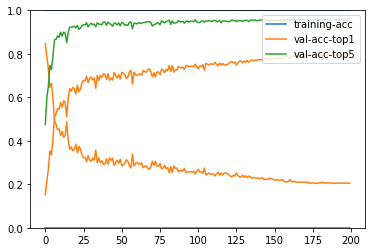

In [98]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])
train_history2 = TrainingHistory(['training-acc', 'val-acc-top1', 'val-acc-top5'])

print("Training loop started for {} epochs:".format(epochs))
for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data  = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        if mixup or stitch_mixup:
            if mixup and not(stitch_mixup):
                lam = np.random.beta(alpha, alpha)
                if epoch >= epochs - mixup_off_epochs:
                    lam = 1
                data = [lam*X + (1-lam)*X[::-1] for X in data]
            
                if label_smoothing:
                    eta = 0.1
                else:
                    eta = 0.0
                label = mixup_transform(label, num_classes, lam, eta)
            
            elif stitch_mixup and not(mixup):
                lam = np.random.beta(alpha, alpha)
                if lam < 0.1:
                    lam = 1
                if epoch >= epochs - mixup_off_epochs:
                    lam = 1
                data = [stitch_mixup_transform(X, lam) for X in data]
                
                if label_smoothing:
                    eta = 0.1
                else:
                    eta = 0.0
                label = stitch_mixup_label_transform(label, num_classes, lam, eta)
            
            else:
                print("No Mixup.")
        
        elif label_smoothing:
            hard_label = label
            label = smooth(label, num_classes)
        
        if distillation:
            teacher_prob = [nd.softmax(teacher(X.astype(dtype, copy=False)) / T) for X in data]

        # AutoGrad
        with ag.record():
            outputs = [net(X.astype(dtype, copy=False)) for X in data]
            if distillation:
                loss = [loss_fn(yhat.astype(dtype, copy=False),
                                y.astype(dtype, copy=False),
                                p.astype(dtype, copy=False)) for yhat, y, p in zip(outputs, 
                                                                                   label, 
                                                                                   teacher_prob)]
            else:
                loss = [loss_fn(yhat, y) for yhat, y in zip(outputs, label)]
            
        # Backpropagation
        for l in loss:
            l.backward()
        
        train_loss += sum([l.sum().asscalar() for l in loss])
            
        # Optimize
        trainer.step(batch_size)
        
        # Update metrics
        if mixup or stitch_mixup:
            output_softmax = [nd.SoftmaxActivation(out.astype(dtype, copy=False)) \
                              for out in outputs]
            train_metric.update(label, output_softmax)
        else:
            if label_smoothing:
                train_metric.update(hard_label, outputs)
            else:
                train_metric.update(label, outputs)

    name, acc = train_metric.get()
    
    # Evaluate on Validation data
    #name, val_acc = test(ctx, val_data)
    val_acc_top1, val_acc_top5 = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc_top1])
    train_history2.update([acc, val_acc_top1, val_acc_top5])
    
    print('[Epoch %d] train=%f val_top1=%f val_top5=%f loss=%f time: %f' %
        (epoch, acc, val_acc_top1, val_acc_top5, train_loss, time.time()-tic))

# We can plot the metric scores with:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_history.plot(['training-error', 'validation-error'], 
                   save_path="./cifar100_resnet56_v1_{o}_{ep}epochs_errors_{t}.png".format(o=optimizer,
                                                                                           ep=epochs,
                                                                                           t=timestamp))
train_history2.plot(['training-acc', 'val-acc-top1', 'val-acc-top5'],
                   save_path="./cifar100_resnet56_v1_{o}_{ep}epochs_accuracies_{t}.png".format(o=optimizer,
                                                                                               ep=epochs,
                                                                                               t=timestamp))
print("Done.")